<a href="https://colab.research.google.com/github/isshii/de4test/blob/test_ozawa/DeepXplore/DeepXplore_02_layer_nc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# base code

In [0]:
# 共通で使うパスなどの定義
# 共通の変数設定
# 共通フォルダパス
data_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data"
data_imagenet = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet"
data_imagenet_seeds = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds"
model_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/model"
output_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/output"
tmp_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/tmp"

In [0]:
# Goggle Drive つなぐ
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# outputフォルダ内容物のクリーンアップ削除
!rm "$output_dir"/*
#!ls "$data_imagenet_seeds"

In [0]:
import argparse

%tensorflow_version 1.x
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.layers import Input
import imageio

Using TensorFlow backend.


In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11028846260809569761, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12543972032146562159
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17840773072539541707
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13187555400513819229
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
#@title デフォルトのタイトル テキスト
# DeepXplore のパラメータ設定部
# read the parameter
# argument parsing
parser = argparse.ArgumentParser(description='Main function for difference-inducing input generation in MNIST dataset')
parser.add_argument('transformation', help="realistic transformation type", choices=['light', 'occl', 'blackout'])
parser.add_argument('weight_diff', help="weight hyperparm to control differential behavior", type=float)
parser.add_argument('weight_nc', help="weight hyperparm to control neuron coverage", type=float)
parser.add_argument('step', help="step size of gradient descent", type=float)
parser.add_argument('seeds', help="number of seeds of input", type=int)
parser.add_argument('grad_iterations', help="number of iterations of gradient descent", type=int)
parser.add_argument('threshold', help="threshold for determining neuron activated", type=float)
parser.add_argument('-t', '--target_model', help="target model that we want it predicts differently",
                    choices=[0, 1, 2], default=0, type=int)
parser.add_argument('-sp', '--start_point', help="occlusion upper left corner coordinate", default=(0, 0), type=tuple)
parser.add_argument('-occl_size', '--occlusion_size', help="occlusion size", default=(10, 10), type=tuple)

_StoreAction(option_strings=['-occl_size', '--occlusion_size'], dest='occlusion_size', nargs=None, const=None, default=(10, 10), type=<class 'tuple'>, choices=None, help='occlusion size', metavar=None)

In [0]:

#@title ノイズのタイプ light / occl / blackout
#@body {light,occl,blackout} weight_diff weight_nc step seeds
#                   grad_iterations threshold
noise_type = "occl" #@param ["light", "occl", "blackout"]
weight_diff = "0.1" #@param {type:"string"}
weight_nc = "0.5" #@param {type:"string"}
step = "0.5" #@param {type:"string"}
seeds = "10" #@param {type:"string"}
grad_iterations = "40" #@param {type:"string"}
threshold = "0.1" #@param {type:"string"}

In [0]:
args = parser.parse_args([noise_type, weight_diff, weight_nc, step, seeds, grad_iterations, threshold])

In [0]:
import random
from collections import defaultdict

import numpy as np
from keras import backend as K
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
from keras.preprocessing import image
import os, re


def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    input_img_data = image.img_to_array(img)
    input_img_data = np.expand_dims(input_img_data, axis=0)
    input_img_data = preprocess_input(input_img_data)  # final input shape = (1,224,224,3)
    return input_img_data


def deprocess_image(x):
    x = x.reshape((224, 224, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def decode_label(pred):
    return decode_predictions(pred)[0][0][1]


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


def constraint_occl(gradients, start_point, rect_shape):
    new_grads = np.zeros_like(gradients)
    new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
    start_point[1]:start_point[1] + rect_shape[1]] = gradients[:, start_point[0]:start_point[0] + rect_shape[0],
                                                     start_point[1]:start_point[1] + rect_shape[1]]
    return new_grads


def constraint_light(gradients):
    new_grads = np.ones_like(gradients)
    grad_mean = 1e4 * np.mean(gradients)
    return grad_mean * new_grads


def constraint_black(gradients, rect_shape=(10, 10)):
    start_point = (
        random.randint(0, gradients.shape[1] - rect_shape[0]), random.randint(0, gradients.shape[2] - rect_shape[1]))
    new_grads = np.zeros_like(gradients)
    patch = gradients[:, start_point[0]:start_point[0] + rect_shape[0], start_point[1]:start_point[1] + rect_shape[1]]
    if np.mean(patch) < 0:
        new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
        start_point[1]:start_point[1] + rect_shape[1]] = -np.ones_like(patch)
    return new_grads


def init_coverage_tables(model1, model2, model3):
    model_layer_dict1 = defaultdict(bool)
    model_layer_dict2 = defaultdict(bool)
    model_layer_dict3 = defaultdict(bool)
    init_dict(model1, model_layer_dict1)
    init_dict(model2, model_layer_dict2)
    init_dict(model3, model_layer_dict3)
    return model_layer_dict1, model_layer_dict2, model_layer_dict3


def init_dict(model, model_layer_dict):
    for layer in model.layers:
        if 'flatten' in layer.name or 'input' in layer.name:
            continue
        for index in range(layer.output_shape[-1]):
            model_layer_dict[(layer.name, index)] = False


def neuron_to_cover(model_layer_dict):
    not_covered = [(layer_name, index) for (layer_name, index), v in list(model_layer_dict.items()) if not v]
    if not_covered:
        layer_name, index = random.choice(not_covered)
    else:
        layer_name, index = random.choice(list(model_layer_dict.keys()))
    return layer_name, index


def neuron_covered(model_layer_dict):
    covered_neurons = len([v for v in list(model_layer_dict.values()) if v])
    total_neurons = len(model_layer_dict)
    return covered_neurons, total_neurons, covered_neurons / float(total_neurons)


def scale(intermediate_layer_output, rmax=1, rmin=0):
    X_std = (intermediate_layer_output - intermediate_layer_output.min()) / (
        intermediate_layer_output.max() - intermediate_layer_output.min())
    X_scaled = X_std * (rmax - rmin) + rmin
    return X_scaled


def update_coverage(input_data, model, model_layer_dict, threshold=0):
    layer_names = [layer.name for layer in model.layers if
                   'flatten' not in layer.name and 'input' not in layer.name]

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=[model.get_layer(layer_name).output for layer_name in layer_names])
    intermediate_layer_outputs = intermediate_layer_model.predict(input_data)

    for i, intermediate_layer_output in enumerate(intermediate_layer_outputs):
        scaled = scale(intermediate_layer_output[0])
        for num_neuron in range(scaled.shape[-1]):
            if np.mean(scaled[..., num_neuron]) > threshold and not model_layer_dict[(layer_names[i], num_neuron)]:
                model_layer_dict[(layer_names[i], num_neuron)] = True


def full_coverage(model_layer_dict):
    if False in list(model_layer_dict.values()):
        return False
    return True


def fired(model, layer_name, index, input_data, threshold=0):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_layer_output = intermediate_layer_model.predict(input_data)[0]
    scaled = scale(intermediate_layer_output)
    if np.mean(scaled[..., index]) > threshold:
        return True
    return False


def diverged(predictions1, predictions2, predictions3, target):
    if not predictions1 == predictions2 == predictions3:
        return True
    return False

#add
def list_pictures(directory, ext='jpg|jpeg|bmp|png|ppm'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f.lower())]

In [0]:
%%time
# input image dimensions
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

# define input tensor as a placeholder
input_tensor = Input(shape=input_shape)

# load multiple models sharing same input tensor
K.set_learning_phase(0)
model1 = VGG16(input_tensor=input_tensor)
model2 = VGG19(input_tensor=input_tensor)
model3 = ResNet50(input_tensor=input_tensor)


# init coverage table
model_layer_dict1, model_layer_dict2, model_layer_dict3 = init_coverage_tables(model1, model2, model3)





553467904/553467096 [==============================] - 6s 0us/step






574717952/574710816 [==============================] - 6s 0us/step


102858752/102853048 [==============================] - 2s 0us/step
CPU times: user 13.6 s, sys: 4.43 s, total: 18 s
Wall time: 27.6 s


In [0]:
# start gen inputs
 img_paths = list_pictures(data_imagenet_seeds)

In [0]:
%%time
for _ in range(args.seeds):
    gen_img = preprocess_image(random.choice(img_paths))
    orig_img = gen_img.copy()
    # first check if input already induces differences
    pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
    label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])
    if not label1 == label2 == label3:
        print('{}/{}. input already causes different outputs: {}, {}, {}'.format(_, args.seeds, decode_label(pred1),decode_label(pred2),decode_label(pred3)))

        update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
        update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
        update_coverage(gen_img, model3, model_layer_dict3, args.threshold)

        print('    covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
              % (len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
                 neuron_covered(model_layer_dict2)[2], len(model_layer_dict3),
                 neuron_covered(model_layer_dict3)[2]))
  
        averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                       neuron_covered(model_layer_dict3)[0]) / float(
            neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
            neuron_covered(model_layer_dict3)[1])
        print('    averaged covered neurons %.3f' % (averaged_nc))

        gen_img_deprocessed = deprocess_image(gen_img)

        # save the result to disk
        outputfilepath0 = os.path.join(output_dir, 'already_differ_' + decode_label(pred1) + '_' + decode_label(pred2) + '_' + decode_label(pred3) + '.png')
        imageio.imwrite(outputfilepath0, gen_img_deprocessed)
        continue

    # if all label agrees
    orig_label = label1
    layer_name1, index1 = neuron_to_cover(model_layer_dict1)
    layer_name2, index2 = neuron_to_cover(model_layer_dict2)
    layer_name3, index3 = neuron_to_cover(model_layer_dict3)

    # construct joint loss function
    if args.target_model == 0:
        loss1 = -args.weight_diff * K.mean(model1.get_layer('predictions').output[..., orig_label])
        loss2 = K.mean(model2.get_layer('predictions').output[..., orig_label])
        loss3 = K.mean(model3.get_layer('fc1000').output[..., orig_label])
    elif args.target_model == 1:
        loss1 = K.mean(model1.get_layer('predictions').output[..., orig_label])
        loss2 = -args.weight_diff * K.mean(model2.get_layer('predictions').output[..., orig_label])
        loss3 = K.mean(model3.get_layer('fc1000').output[..., orig_label])
    elif args.target_model == 2:
        loss1 = K.mean(model1.get_layer('predictions').output[..., label1])
        loss2 = K.mean(model2.get_layer('predictions').output[..., orig_label])
        loss3 = -args.weight_diff * K.mean(model3.get_layer('fc1000').output[..., orig_label])
    loss1_neuron = K.mean(model1.get_layer(layer_name1).output[..., index1])
    loss2_neuron = K.mean(model2.get_layer(layer_name2).output[..., index2])
    loss3_neuron = K.mean(model3.get_layer(layer_name3).output[..., index3])
    layer_output = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)

    # for adversarial image generation
    final_loss = K.mean(layer_output)

    # we compute the gradient of the input picture wrt this loss
    grads = normalize(K.gradients(final_loss, input_tensor)[0])

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_tensor], [loss1, loss2, loss3, loss1_neuron, loss2_neuron, loss3_neuron, grads])

    # we run gradient ascent for 20 steps
    for iters in range(args.grad_iterations):



        loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = iterate(
            [gen_img])
        if args.transformation == 'light':
            grads_value = constraint_light(grads_value)  # constraint the gradients value
        elif args.transformation == 'occl':
            grads_value = constraint_occl(grads_value, args.start_point,
                                          args.occlusion_size)  # constraint the gradients value
        elif args.transformation == 'blackout':
            grads_value = constraint_black(grads_value)  # constraint the gradients value

        gen_img += grads_value * args.step
        pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
        label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])

        if not label1 == label2 == label3:
            update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
            update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
            update_coverage(gen_img, model3, model_layer_dict3, args.threshold)
            averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                           neuron_covered(model_layer_dict3)[0]) / float(
                neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
                neuron_covered(model_layer_dict3)[
                    1])
            print('%d/%d. averaged covered neurons %.3f' % (_, args.seeds, averaged_nc))

            gen_img_deprocessed = deprocess_image(gen_img)
            orig_img_deprocessed = deprocess_image(orig_img)

            # save the result to disk
            outputfilepath = os.path.join(output_dir, args.transformation + '_' + decode_label(pred1) + '_' + decode_label(pred2) + '_' + decode_label(pred3) + '.png')
            print(outputfilepath)
            imageio.imwrite(outputfilepath, gen_img_deprocessed)
            outputfilepath2 = os.path.join(output_dir, args.transformation + '_' + decode_label(pred1) + '_' + decode_label(pred2) + '_' + decode_label(pred3) + '_orig.png')
            print(outputfilepath2)
            imageio.imwrite(outputfilepath2, orig_img_deprocessed)
            break

        #add
        if iters == (args.grad_iterations-1):
            update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
            update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
            update_coverage(gen_img, model3, model_layer_dict3, args.threshold)
            averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                           neuron_covered(model_layer_dict3)[0]) / float(
                neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
                neuron_covered(model_layer_dict3)[
                    1])
            print('%d/%d. test suite was not found: averaged covered neurons %.3f' % (_, args.seeds, averaged_nc))

40960/35363 [==================================] - 0s 0us/step
0/10. input already causes different outputs: kimono, kimono, ashcan
    covered neurons percentage 14888 neurons 0.089, 16168 neurons 0.088, 94123 neurons 0.742
    averaged covered neurons 0.580
1/10. test suite was not found: averaged covered neurons 0.611
2/10. test suite was not found: averaged covered neurons 0.626
3/10. test suite was not found: averaged covered neurons 0.654
4/10. input already causes different outputs: seashore, wreck, promontory
    covered neurons percentage 14888 neurons 0.359, 16168 neurons 0.346, 94123 neurons 0.770
    averaged covered neurons 0.666
5/10. input already causes different outputs: Sussex_spaniel, Australian_terrier, Chesapeake_Bay_retriever
    covered neurons percentage 14888 neurons 0.395, 16168 neurons 0.385, 94123 neurons 0.777
    averaged covered neurons 0.681
6/10. test suite was not found: averaged covered neurons 0.692
7/10. input already causes different outputs: dock,

#02 neuron coverage 測定
##02 01 layerごと

In [0]:
%%time
#list(model_layer_dict1.keys())
data_list_layer_nc = list([x[0][0], x[1]] for x in model_layer_dict3.items())
data_list_layer = list(x[0][0] for x in model_layer_dict3.items())
data_list_nc = list(x[1] for x in model_layer_dict3.items())
#print(len(x))
print([len(data_list_layer_nc), len(data_list_layer_nc[0]), len(data_list_layer), len(data_list_nc)])
#import matplotlib
#matplotlib.pyplot.hist(x)


data_list_layer_nc_on = list(x[0][0] for x in model_layer_dict3.items() if x[1]==True)
data_list_layer_nc_off = list(x[0][0] for x in model_layer_dict3.items() if x[1]==False)
print(len(data_list_layer_nc_on), len(data_list_layer_nc_off), len(data_list_layer_nc_on)+len(data_list_layer_nc_off))
data_list_layer_name = list(x[0][0] for x in model_layer_dict3.items() if x[0][1]==0)
print(len(data_list_layer_name))
bins = len(data_list_layer_name)

data_list_layer_nc_0 = list(0 for x in model_layer_dict3.items() if x[1]==True)



[94123, 2, 94123, 94123]
74179 19944 94123
176
CPU times: user 293 ms, sys: 2.99 ms, total: 296 ms
Wall time: 296 ms


Text(0, 0.5, '# of neurons')

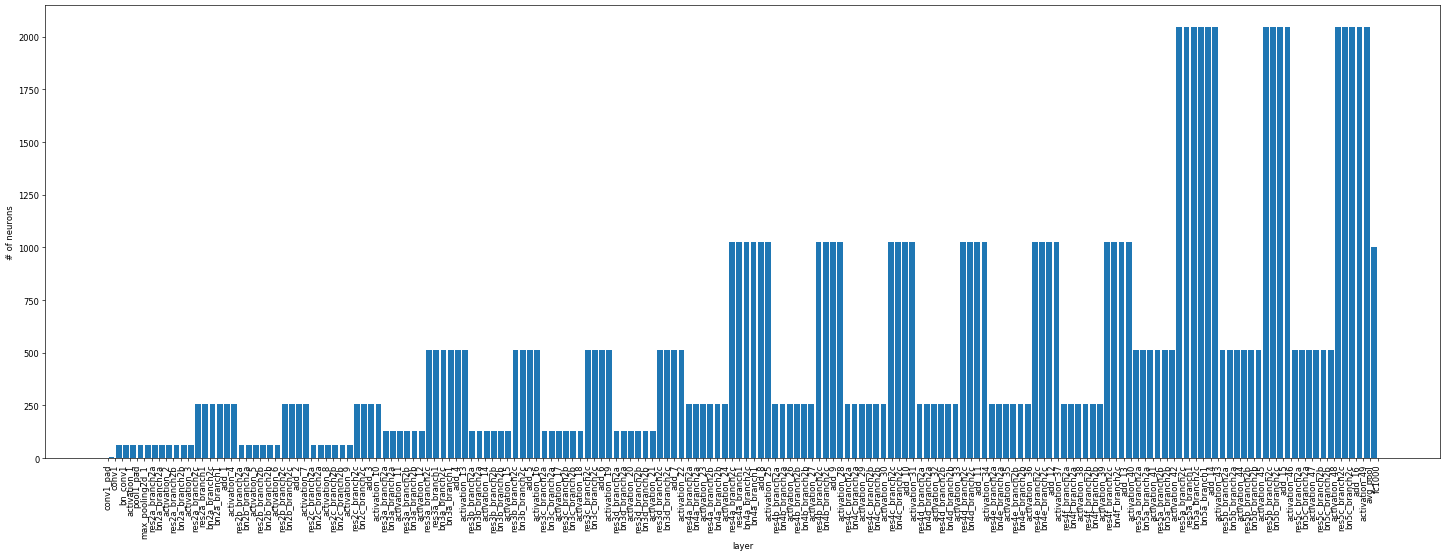

In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


fig = plt.figure(figsize=(30,10),dpi=60)
#ax = fig.add_subplot(1,2,1)
ax = fig.add_subplot(1,1,1)
matplotlib.pyplot.hist(data_list_layer, rwidth=0.8, bins=bins)
# x軸縦書き。
plt.xticks(rotation=90)
ax.set_xlabel('layer')
ax.set_ylabel('# of neurons')

#ax = fig.add_subplot(1,2,2)
#matplotlib.pyplot.hist(data_list_layer, rwidth=0.8, bins=bins)
## x 軸のラベル
#dt_labels = [dt.strftime('%H:%M') for dt in df['datetime']]  # ラベル一覧作成
## 4つおきにラベルを表示する。
#plt.xticks(rotation=90)
#plt.ylim(0,12000)

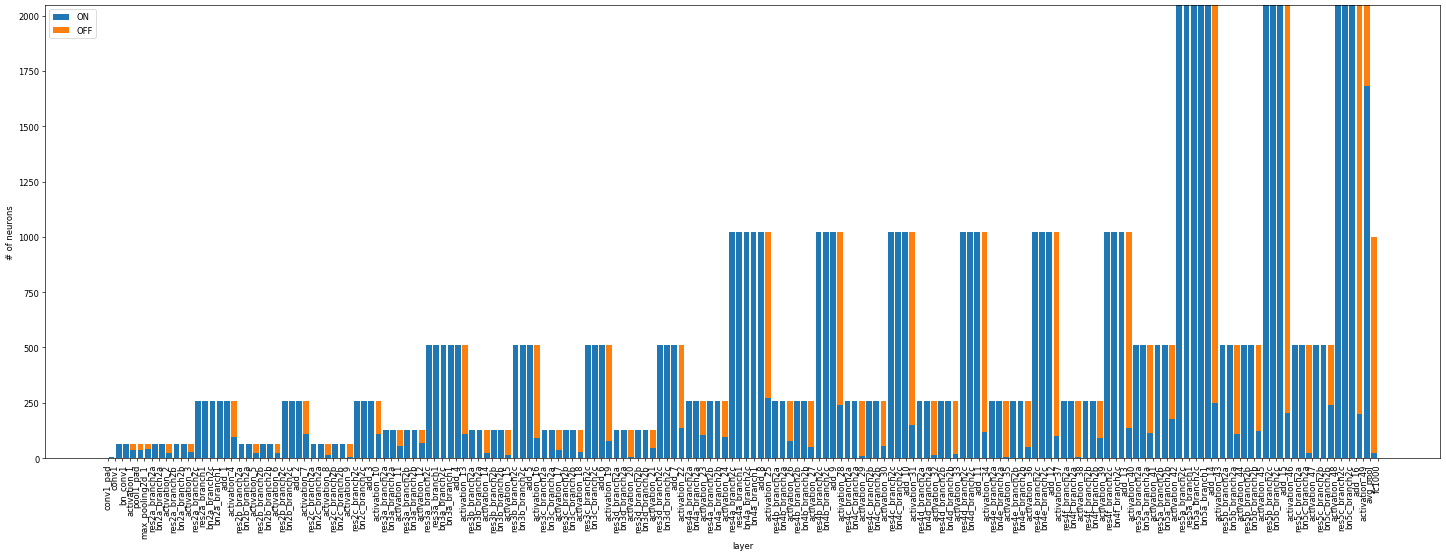

In [0]:
fig = plt.figure(figsize=(30,10),dpi=60)
#ax = fig.add_subplot(1,2,1)
ax = fig.add_subplot(1,1,1)
#ax.hist([data_list_layer_nc_on, data_list_layer_nc_off],label=['ON', 'OFF'], histtype='bar', stacked=True, rwidth=0.9, bins=bins)
ax.hist([data_list_layer_nc_on, data_list_layer_nc_off],label=['ON','OFF'], histtype='bar', stacked=True, rwidth=0.8, bins=bins)
#ax.hist(data_list_layer_nc_on,label='ON', histtype='bar', rwidth=0.9, bins=bins)
plt.xticks(rotation=90)
ax.set_xlabel('layer')
ax.set_ylabel('# of neurons')
ax.legend(loc='upper left')
#ax = fig.add_subplot(1,2,2)
#ax.hist([data_list_layer_nc_on, data_list_layer_nc_off],label=['ON', 'OFF'], histtype='bar', stacked=False, rwidth=0.9, bins=bins)
#plt.xticks(rotation=90)
#ax.set_xlabel('layer')
#ax.set_ylabel('# of neurons')
#ax.legend(loc='upper left')
#plt.ylim(0,100)